In [243]:
# 0. Dependencias

# pip install pandas requests lxml sqlalchemy python-dotenv beautifulsoup4

import os
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
from sqlalchemy import create_engine, text
from datetime import datetime
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DATABASE_URL", "sqlite:///./spotify_streams.db")
TARGET_URL = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"


In [244]:
# 1. Descargar el HTML (con headers para evitar 403)

def fetch_html_with_headers(url, timeout=15):
    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                      "(KHTML, like Gecko) Chrome/120.0 Safari/537.36 - DataScienceBot/1.0 (contact: tú@ejemplo.com)"
    }
    resp = requests.get(url, headers=headers, timeout=timeout)
    resp.raise_for_status()
    return resp.text

html = fetch_html_with_headers(TARGET_URL)
print("HTML descargado. longitud:", len(html))

HTML descargado. longitud: 680018


fetch_html_with_headers: descarga la página como si fueras un navegador, evitando 403.

In [245]:
# 2. Intento con pandas.read_html

def parse_tables_with_pandas(html):
    # pd.read_html acepta texto HTML y devuelve una lista de DataFrames
    tables = pd.read_html(html)
    print(f"read_html encontró {len(tables)} tablas")
    return tables

tables = parse_tables_with_pandas(html)
# revisar índices y elegir la tabla correcta
for i, t in enumerate(tables):
    print(i, t.shape, t.columns.tolist())

read_html encontró 27 tablas
0 (101, 6) ['Rank', 'Song', 'Artist(s)', 'Streams (billions)', 'Release date', 'Ref.']
1 (14, 13) [('Rank', 'Rank'), ('Artist', 'Artist'), ('Top 100', 'Total songs'), ('Top 100', 'Lead'), ('Top 100', 'Feat.'), ('Top 10', 'Lead'), ('Top 10', 'Feat.'), ('3 billion+ streams', 'Lead'), ('3 billion+ streams', 'Feat.'), ('4 billion+ streams', 'Lead'), ('4 billion+ streams', 'Feat.'), ('5 billion+ streams', 'Lead'), ('5 billion+ streams', 'Feat.')]
2 (10, 9) ['No.', 'Song', 'Artist(s)', 'Streams (billions)', 'Release date', 'Date achieved', 'Days held', 'Ref.', 'Notes']
3 (2, 2) [0, 1]
4 (132, 6) ['Song[114]', 'Artist(s)', 'Release date', 'Issue date', 'Wks.', 'Avs.']
5 (13, 6) [('Year', 'Year'), ('Artist and Song ranking', '1'), ('Artist and Song ranking', '2'), ('Artist and Song ranking', '3'), ('Artist and Song ranking', '4'), ('Artist and Song ranking', '5')]
6 (4, 2) ['Year', 'Artist and song']
7 (20, 7) ['Rank', 'Song', 'Artist(s)', 'Streams', 'Date publishe

/tmp/ipykernel_1581/747427231.py:5: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html)


parse_tables_with_pandas: intenta parsear todas las tablas HTML rápidamente.

Normalización de columnas: convierte nombres a snake_case para trabajar fácil.

In [246]:
# 3. Elegir y revisar la tabla

# En la wiki en general la tabla principal suele estar en tables[0] o tables[1]
df_raw = tables[0].copy()
df_raw.head()

,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,5.111,29 November 2019,[1]
1,2,"""Shape of You""",Ed Sheeran,4.622,6 January 2017,[2]
2,3,"""Starboy""",The Weeknd and Daft Punk,4.177,21 September 2016,[3]
3,4,"""Sweater Weather""",The Neighbourhood,4.135,3 December 2012,[4]
4,5,"""Someone You Loved""",Lewis Capaldi,4.110,8 November 2018,[5]


In [247]:
# 4. Limpieza específica (streams, artista, title, year)

# Ejemplo general para la columna de reproducciones
def parse_streams_value(x):
    if pd.isna(x):
        return None
    s = str(x).strip()
    # Si contiene 'B' o 'M' (billions/millions), tratarlas
    s = s.replace('\xa0', '')  # nbsp
    # Detectar sufijos
    m = re.match(r'^([\d,.]+)\s*B$', s, flags=re.IGNORECASE)
    if m:
        num = float(m.group(1).replace(',', ''))
        return int(num * 1_000_000_000)
    m = re.match(r'^([\d,.]+)\s*M$', s, flags=re.IGNORECASE)
    if m:
        num = float(m.group(1).replace(',', ''))
        return int(num * 1_000_000)
    # Si tiene comas o puntos de miles:
    s_digits = re.sub(r'[^\d.]', '', s)
    if s_digits == '':
        return None
    # Si hay más de 10 dígitos puede ser int directo
    try:
        if '.' in s_digits:
            return float(s_digits)
        else:
            return int(s_digits)
    except:
        return None

# Aplicar limpieza a columnas típicas
df = df_raw.copy()

# Normalizar nombres de columna
df.columns = [str(c).strip().lower().replace(' ', '_') for c in df.columns]
print("Columnas tras normalizar:", df.columns.tolist())

# Detectar columna de streams (puede llamarse 'reproductions', 'streams' o 'streams (billions)' etc.)
possible_stream_cols = [c for c in df.columns if 'stream' in c or 'repro' in c or 'plays' in c]
print("Candidatas a columna de streams:", possible_stream_cols)

Columnas tras normalizar: ['rank', 'song', 'artist(s)', 'streams_(billions)', 'release_date', 'ref.']
Candidatas a columna de streams: ['streams_(billions)']


parse_streams_value: limpia valores de streams con distintas notaciones (10.5B, 1,234,567) y los convierte a int (nº de reproducciones).

In [248]:
# Ajustar según la columna detectada; ejemplo asume 'streams' o la 3ª columna

# Revisa df.head() y cambia 'streams' por el nombre correcto si hace falta
streams_col = possible_stream_cols[0] if possible_stream_cols else df.columns[2]  # fallback
print("Usando columna streams:", streams_col)

# Convertir streams
df['streams_clean'] = df[streams_col].apply(parse_streams_value)

# Otras columnas: título, artista, año
# Busca nombres probables
title_col = [c for c in df.columns if 'title' in c or 'song' in c or 'track' in c]
artist_col = [c for c in df.columns if 'artist' in c or 'performer' in c]
year_col = [c for c in df.columns if 'year' in c or 'released' in c]

print("title_col", title_col, "artist_col", artist_col, "year_col", year_col)

# Normalizar columnas objetivo si existen
if title_col:
    df['title'] = df[title_col[0]]
if artist_col:
    df['artist'] = df[artist_col[0]]
if year_col:
    df['release_year'] = df[year_col[0]]

# Keep only useful cols
cols_keep = [c for c in ['title', 'artist', 'streams_clean', 'release_year'] if c in df.columns]
df_clean = df[cols_keep].copy()
df_clean = df_clean.dropna(subset=['title', 'artist', 'streams_clean']).drop_duplicates().reset_index(drop=True)
df_clean['streams_clean'] = df_clean['streams_clean'].astype(int)
df_clean.head()

Usando columna streams: streams_(billions)
title_col ['song'] artist_col ['artist(s)'] year_col []


,title,artist,streams_clean
0,"""Blinding Lights""",The Weeknd,5
1,"""Shape of You""",Ed Sheeran,4
2,"""Starboy""",The Weeknd and Daft Punk,4
3,"""Sweater Weather""",The Neighbourhood,4
4,"""Someone You Loved""",Lewis Capaldi,4


In [249]:
# 5. Guardar en SQLite usando SQLAlchemy

import sqlite3
from datetime import datetime

DB_PATH = "spotify_streams.db"

def save_to_sqlite(df, table_name="most_streamed_spotify", db_path=DB_PATH):
    # Conectamos con sqlite3
    conn = sqlite3.connect(db_path)
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    
    # Verificamos cuántas filas se guardaron
    cursor = conn.cursor()
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    count = cursor.fetchone()[0]
    conn.close()
    
    print(f"Guardado exitoso en '{db_path}', tabla '{table_name}'. Filas: {count}")

# Agregar columna de fecha del scraping
df_clean['scraping_date'] = datetime.utcnow().date()

# Guardar
save_to_sqlite(df_clean, "most_streamed_spotify")

Guardado exitoso en 'spotify_streams.db', tabla 'most_streamed_spotify'. Filas: 101


In [250]:
#Verificar que la tabla existe y tiene datos

import sqlite3

conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

cursor.execute("SELECT * FROM most_streamed_spotify LIMIT 5")
rows = cursor.fetchall()

for row in rows:
    print(row)

conn.close()

('"Blinding Lights"', 'The Weeknd', 5, '2025-11-03')
('"Shape of You"', 'Ed Sheeran', 4, '2025-11-03')
('"Starboy"', 'The Weeknd and Daft Punk', 4, '2025-11-03')
('"Sweater Weather"', 'The Neighbourhood', 4, '2025-11-03')
('"Someone You Loved"', 'Lewis Capaldi', 4, '2025-11-03')


In [251]:
# Normalizar columnas
df = df.copy()
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace(r"[^a-z0-9_]", "", regex=True)

# Renombrar columnas según lo esperado
rename_dict = {}
for col in df.columns:
    if "song" in col or "title" in col:
        rename_dict[col] = "title"
    elif "artist" in col:
        rename_dict[col] = "artist"
    elif "stream" in col:
        rename_dict[col] = "streams"
    elif "release" in col:
        rename_dict[col] = "release_date"
    elif col == "rank":
        rename_dict[col] = "rank"

df = df.rename(columns=rename_dict)

# Eliminar columnas duplicadas
df = df.loc[:,~df.columns.duplicated()]

print("Columnas finales:", df.columns.tolist())

Columnas finales: ['rank', 'title', 'artist', 'streams', 'release_date', 'ref']


Columnas disponibles: ['rank', 'title', 'artist', 'streams', 'release_date', 'ref']
Columnas renombradas: ['rank', 'title', 'artist', 'streams', 'release_date', 'ref']
Filas tras limpieza: 100
--- INSIGHTS ---
Total de streams (billones): 298.83
Promedio de streams por canción: 2.99
Más escuchada: '"Blinding Lights"' de The Weeknd



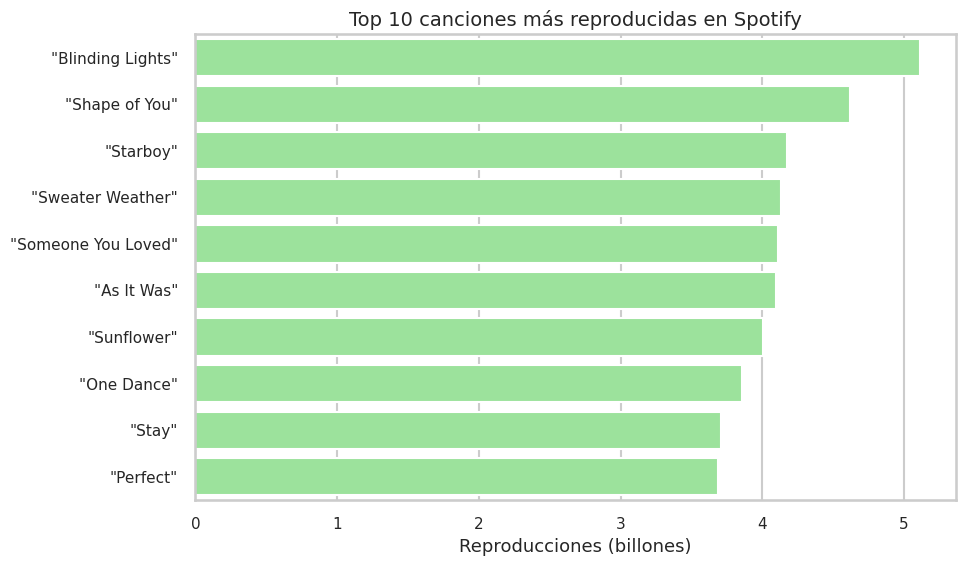

/tmp/ipykernel_1581/1134882715.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


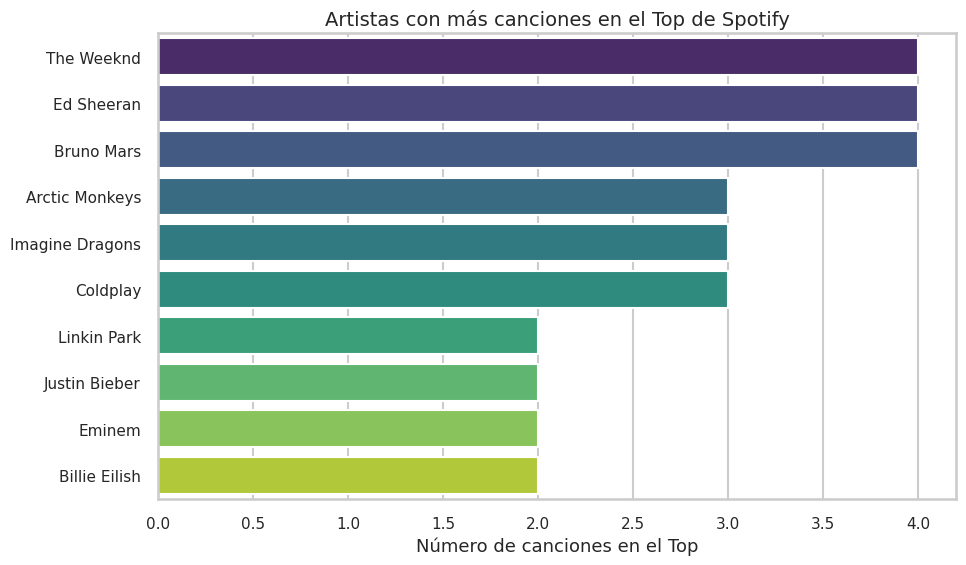

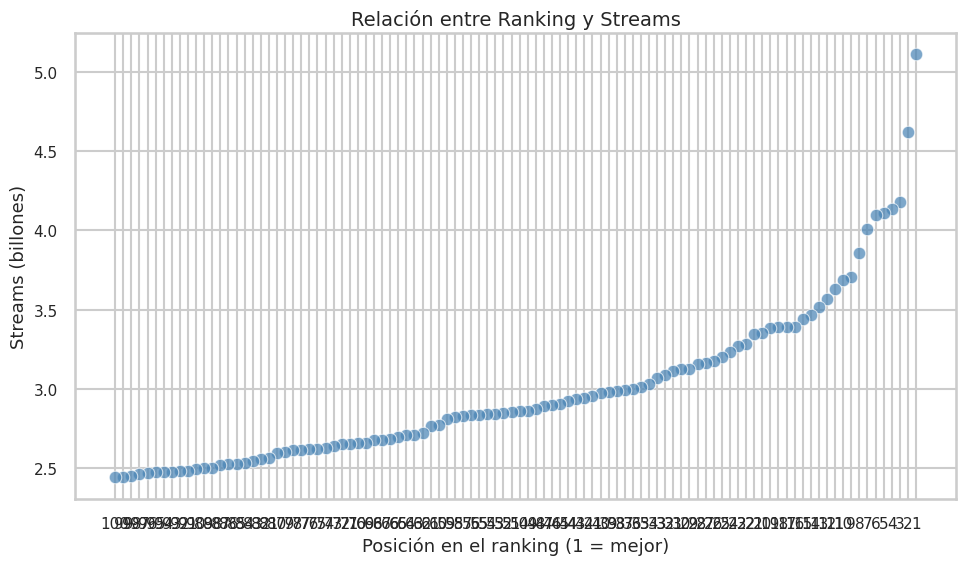

In [252]:
# Visualizaciones de Spotify

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =======================
# Normalización de columnas
# =======================
df = df.copy()
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace(r"[^a-z0-9_]", "", regex=True)
print("Columnas disponibles:", df.columns.tolist())

# Intentar mapear nombres esperados
rename_dict = {}

for col in df.columns:
    if "song" in col or "title" in col:
        rename_dict[col] = "title"
    elif "artist" in col:
        rename_dict[col] = "artist"
    elif "stream" in col:
        rename_dict[col] = "streams"
    elif "release" in col:
        rename_dict[col] = "release_date"
    elif col == "rank":
        rename_dict[col] = "rank"

df = df.rename(columns=rename_dict)
print("Columnas renombradas:", df.columns.tolist())

# =======================
# Limpieza básica
# =======================
# Eliminar filas basura como “as of 2 november 2025”
if "title" in df.columns:
    df = df[~df["title"].astype(str).str.contains("as of", case=False, na=False)]
if "artist" in df.columns:
    df = df[~df["artist"].astype(str).str.contains("as of", case=False, na=False)]

# Convertir streams a numérico
if "streams" in df.columns:
    df["streams"] = pd.to_numeric(df["streams"], errors="coerce")

# Eliminar nulos
df = df.dropna(subset=["streams"])
print(f"Filas tras limpieza: {len(df)}")

# =======================
# Insights rápidos
# =======================
total_streams = df["streams"].sum()
avg_streams = df["streams"].mean()
top_song = df.loc[df["streams"].idxmax(), "title"]
top_artist = df.loc[df["streams"].idxmax(), "artist"]

print(f"--- INSIGHTS ---")
print(f"Total de streams (billones): {total_streams:.2f}")
print(f"Promedio de streams por canción: {avg_streams:.2f}")
print(f"Más escuchada: '{top_song}' de {top_artist}")
print()

# =======================
# Gráfico 1: Top 10 canciones
# =======================
plt.figure(figsize=(10,6))
sns.barplot(
    data=df.nlargest(10, "streams"),
    x="streams",
    y="title",
    color="lightgreen"  # cambia a color único
)
plt.title("Top 10 canciones más reproducidas en Spotify", fontsize=14)
plt.xlabel("Reproducciones (billones)")
plt.ylabel("")
plt.tight_layout()
plt.show()

# =======================
# Gráfico 2: Artistas con más canciones en el Top
# =======================
plt.figure(figsize=(10,6))
artist_counts = df["artist"].value_counts().head(10)
colors = sns.color_palette("viridis", len(artist_counts))
sns.barplot(
    x=artist_counts.values,
    y=artist_counts.index,
    palette=colors
)
plt.title("Artistas con más canciones en el Top de Spotify", fontsize=14)
plt.xlabel("Número de canciones en el Top")
plt.ylabel("")
plt.tight_layout()
plt.show()

# =======================
# Gráfico 3: Relación entre Ranking y Streams
# =======================
if "rank" in df.columns:
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=df,
        x="rank",
        y="streams",
        color="steelblue",
        alpha=0.7
    )
    plt.gca().invert_xaxis()  # Rank 1 a la izquierda
    plt.title("Relación entre Ranking y Streams", fontsize=14)
    plt.xlabel("Posición en el ranking (1 = mejor)")
    plt.ylabel("Streams (billones)")
    plt.tight_layout()
    plt.show()
else:
    print("No hay columna 'rank' para el análisis de dispersión.")
